In [2]:
# Peter Karras 2020
'''Takes GPP and date information from old master file and creates a new Machine Learning Master File
   With one column representing file names for the converted CSVs and the other column being their respective
   GPPs as pulled from the old master file or calculated with linear interpolation'''

'Takes GPP and date information from old master file and creates a new Machine Learning Master File\n   With one column representing file names for the converted CSVs and the other column being their respective\n   GPPs as pulled from the old master file or calculated with linear interpolation'

In [10]:
import pandas as pd
import os
import csv
import time
import fnmatch


In [11]:
lst = ['bust','just','fust','bst']
filtered = fnmatch.filter(lst, '["bu",fu]st')
print(filtered)

['bst']


In [12]:
# Takes in a string that represents name of csv file and 
# converts that string to one that matches the date string present
# in the old master file (old master file refers to the raw excel file
# filled with extraneous data from BCI)that contains the date/times 
# for recorded GPP values
def change_csv_date(csv):
    minDivFiveFlag = True
    year = csv[2:4]
    month = csv[5:7]
    day = csv[8:10]
    hour = csv[11:13]
    minute = csv[14:16]
    second = "00"
    if (int(minute) % 5) != 0:
        print("THIS:", csv, "minute not divisible by 5")
        minDivFiveFlag = False
    if(int(hour) == 0):
        hour = "0"
    elif(int(hour) < 10):
        hour = hour[1:2]
    # No leading zeroes in day or month
    if(int(month) < 10):
        month = month[1:2]
    if(int(day) < 10):
        day = day[1:2]
    result = month + "/" + day + "/" + year + " " + hour + ":" + minute #+ ":" + second + " " + timeDay
    return result, minDivFiveFlag

# USE MAKE MASTER TO CREATE MULTIPLE populatedGPP files that hold mar, april, may etc

In [13]:
# Function that checks if time/date is at 00 minutes
def check_zero_time_min(csv):
    if csv[14:16] == "00":
        return True
    else:
        return False
#  and 30 minutes
def check_thirty_time_min(csv):
    if csv[14:16] == "30":
        return True
    else:
        return False

In [14]:
# Takes in csv date (in format 'YYYY_MM_DD_HH_MM_bci_t') and checks to see if minutes are divisble by div
def check_csv_date(csv, div):
    result = False
    minute = int(csv[14:16])
    remainder = minute % div
    if(remainder == 0):
        result = True
    else:
        result = False
    return result

In [15]:
print(check_csv_date("2015_03_14_14_00_bci_t.csv",30))

True


In [16]:
print(check_thirty_time_min("2015_03_14_14_30_bci_t.csv"))

True


In [33]:
# Grabs all GPP values and dates from master file (as defined above)
masterfileLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2"
os.chdir(masterfileLocation)
col_list = ["date", "GPP"]
masterFileName = "all-30min-Apr2018_working.csv"
dateGPPList = pd.read_csv(masterFileName, usecols=col_list) 
dateGPPList = dateGPPList.set_index("date")
csv_file1 = "populatedGPPsMORN.csv"

csvdataLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2\csvdataFULL\BCIML_Dataset"
(_, _, csvfiles) = next(os.walk(csvdataLocation))
#remove previus populated GPPs file if present
csvfiles.remove("populatedGPPsSEP.csv")
#csvfiles.remove("gpp_file.png")
print(csvfiles[len(csvfiles)-1])
print(len(csvfiles))

# Crude way of removing undesired parts of data (if only certain months wanted etc.)
"""
Files are formatted as such: 2015_04_28_02_15_bci_t
with the first file being: 2015_03_14_13_30_bci_t
and the last file being:   2015_10_01_00_55_bci_t SO BASICALLY UNTIL end of September
"""
# file name wanted
# desiredNameList = ["2015"]
# counter = 0
# while counter < len(csvfiles):
#     pickedFile = csvfiles[counter]
#     for desiredName in desiredNameList:
#         if desiredName not in pickedFile:
#             del csvfiles[counter]
#             counter = counter - 1
#             break
#     counter = counter + 1
#print("fin:",len(csvfiles))

# File name filtering improvement
csvfiles1 = fnmatch.filter(csvfiles, '2015_??_??_0[456789]_??_bci_t.csv')
csvfiles2 = fnmatch.filter(csvfiles, '2015_??_??_1[01]_??_bci_t.csv')
csvfiles3 = fnmatch.filter(csvfiles, '2015_??_??_12_00_bci_t.csv')
csvfiles1.extend(csvfiles2)
csvfiles1.extend(csvfiles3)
csvfiles = csvfiles1

print(csvfiles)

model_BCI.pt
55375
['2015_03_15_04_00_bci_t.csv', '2015_03_15_04_05_bci_t.csv', '2015_03_15_04_10_bci_t.csv', '2015_03_15_04_15_bci_t.csv', '2015_03_15_04_20_bci_t.csv', '2015_03_15_04_25_bci_t.csv', '2015_03_15_04_30_bci_t.csv', '2015_03_15_04_35_bci_t.csv', '2015_03_15_04_40_bci_t.csv', '2015_03_15_04_45_bci_t.csv', '2015_03_15_04_50_bci_t.csv', '2015_03_15_04_55_bci_t.csv', '2015_03_15_05_00_bci_t.csv', '2015_03_15_05_05_bci_t.csv', '2015_03_15_05_10_bci_t.csv', '2015_03_15_05_15_bci_t.csv', '2015_03_15_05_20_bci_t.csv', '2015_03_15_05_25_bci_t.csv', '2015_03_15_05_30_bci_t.csv', '2015_03_15_05_35_bci_t.csv', '2015_03_15_05_40_bci_t.csv', '2015_03_15_05_45_bci_t.csv', '2015_03_15_05_50_bci_t.csv', '2015_03_15_05_55_bci_t.csv', '2015_03_15_06_00_bci_t.csv', '2015_03_15_06_05_bci_t.csv', '2015_03_15_06_10_bci_t.csv', '2015_03_15_06_15_bci_t.csv', '2015_03_15_06_20_bci_t.csv', '2015_03_15_06_25_bci_t.csv', '2015_03_15_06_30_bci_t.csv', '2015_03_15_06_35_bci_t.csv', '2015_03_15_06_40_bc

In [34]:
# This chunk of code matches the file names from the old master file to the
# names gotten from the "csvdata" folder, so that each thermal csv file has it's
# corresponding GPP value matched to it
# NOTE: In addition to matching GPP values, this code also fills in GPP values
# for those images without recorded values through linear interpoaltion


dictList = list()

counter = 0
numLoops = len(csvfiles)
oldGPP = -1.1
gapCounter = 0
#5448
GPPDataDict = dict()
for i in range(0, numLoops, 6):
    #GPPDataDict.clear()
    currFile = csvfiles[i]
    print("processing step ",i, ":", currFile)
    adaptedDate, minDivFiveFlag = change_csv_date(currFile)
    # If value is not at a 5 minute interval we ignore it (already have pleeenttyy of data)
    if not minDivFiveFlag:
        continue
    # Try to see if our date/time is the start/end of a GPP record (30 min interval)
    # This is done to accomodate for the linear interpolation that occurs later
    try:
        currGPP = dateGPPList.at[adaptedDate,"GPP"]
    except:
        print("Gap in time: ", adaptedDate)
        for num in range(1,6):
            adaptedDate, _ = change_csv_date(csvfiles[i+num])
            try:
                currGPP = dateGPPList.at[adaptedDate,"GPP"]
                break
            except:
                currGPP = -101
        if currGPP == -101:
            continue
            gapCounter += 1
    if(i == 0):
        GPPDataDict.update({"GPP" : currGPP})
        GPPDataDict.update({"FILE" : currFile})
        print("Dict Updated with:",currFile, ":", currGPP)
        dictList.append(GPPDataDict)
        oldGPP = currGPP
        continue
        
    GPPDataDictTemp = dict()
    GPPDataDictTemp.update({"GPP" : currGPP})
    GPPDataDictTemp.update({"FILE" : currFile})
    print("TEMP dict updated with:",currFile, ":", currGPP)

    
    
    diffGPP = currGPP - oldGPP
    increment = diffGPP / 6.0
    
    
#     for j in range(i-5, i, 1):
#         oldGPP += increment
#         currFile = csvfiles[j]
#         #print("Here", currFile)
#         GPPDataDict = dict()
#         GPPDataDict.update({"GPP" : oldGPP})
#         GPPDataDict.update({"FILE" : currFile})
#         dictList.append(GPPDataDict)
        
    # Need 6 values to interpolate correctly aka minutes 5,10,15,20,25,30 or 35,40,45,50,55,0
    countInterPolate = 0
    # j represents current index of file that needs a GPP value estimated through interpolation
    j = i-5
    # Determines what we are looking for, if we are currently at 00, we are looking for previous half hour (going back)
    # so something that has the time xx:30 and vice versa
    lookFor = ""
    if check_thirty_time_min(currFile):
        lookFor = "00"
    else:
        lookFor = "30"
    while countInterPolate != 5:
        currFile = csvfiles[j]
        if not lookFor == "nothing":
            if lookFor == "00":
                if not check_zero_time_min(currFile):
                    j = j-1
                    continue
                else:
                    # Reached 00 time, move onto the next
                    lookFor = "nothing"
                    j = j+1
                    continue
            elif lookFor == "30":
                if not check_thirty_time_min(currFile):
                    j = j-1
                    continue
                else:
                    # Reached 30 time, move onto the next
                    lookFor = "nothing"
                    j = j+1
                    continue
        else:
            currFile = csvfiles[j]
            _, minDivFiveFlag = change_csv_date(currFile)
            # If value not divsible by five, move on!
            if not minDivFiveFlag:
                j = j+1
                continue
            oldGPP += increment

        GPPDataDict = dict()
        GPPDataDict.update({"GPP" : oldGPP})
        GPPDataDict.update({"FILE" : currFile})
        print("Dict Updated with:",currFile, ":", oldGPP)

        dictList.append(GPPDataDict)
        # Reaching this point means we found a valid value, add it to dict and increment index
        countInterPolate = countInterPolate + 1
        j = j+1
        
        
        
    
    dictList.append(GPPDataDictTemp)
    oldGPP = currGPP + increment
    oldGPP = currGPP

processing step  0 : 2015_03_15_04_00_bci_t.csv
Dict Updated with: 2015_03_15_04_00_bci_t.csv : 0.0
processing step  6 : 2015_03_15_04_30_bci_t.csv
TEMP dict updated with: 2015_03_15_04_30_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_05_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_10_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_15_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_20_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_25_bci_t.csv : 0.0
processing step  12 : 2015_03_15_05_00_bci_t.csv
TEMP dict updated with: 2015_03_15_05_00_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_35_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_40_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_45_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_50_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_04_55_bci_t.csv : 0.0
processing step  18 : 2015_03_15_05_30_bci_t.csv
TEMP dict updated with: 2015_03_15_05_30_bci_t.csv : 0.0
Dict Updated with: 2015_03_15_05_05_bci_t.csv : 0.0
Dict Update

Dict Updated with: 2015_03_23_07_45_bci_t.csv : 11.091583264999999
Dict Updated with: 2015_03_23_07_50_bci_t.csv : 11.371989656666665
Dict Updated with: 2015_03_23_07_55_bci_t.csv : 11.652396048333332
processing step  630 : 2015_03_23_08_30_bci_t.csv
TEMP dict updated with: 2015_03_23_08_30_bci_t.csv : 14.546828699999999
Dict Updated with: 2015_03_23_08_05_bci_t.csv : 12.368473483333332
Dict Updated with: 2015_03_23_08_10_bci_t.csv : 12.804144526666665
Dict Updated with: 2015_03_23_08_15_bci_t.csv : 13.239815569999998
Dict Updated with: 2015_03_23_08_20_bci_t.csv : 13.67548661333333
Dict Updated with: 2015_03_23_08_25_bci_t.csv : 14.111157656666663
processing step  636 : 2015_03_23_09_00_bci_t.csv
TEMP dict updated with: 2015_03_23_09_00_bci_t.csv : 15.91075921
Dict Updated with: 2015_03_23_08_35_bci_t.csv : 14.774150451666666
Dict Updated with: 2015_03_23_08_40_bci_t.csv : 15.001472203333332
Dict Updated with: 2015_03_23_08_45_bci_t.csv : 15.228793954999999
Dict Updated with: 2015_03_

Dict Updated with: 2015_04_01_07_20_bci_t.csv : 8.766819197333334
Dict Updated with: 2015_04_01_07_25_bci_t.csv : 9.391529658666666
processing step  1272 : 2015_04_01_08_00_bci_t.csv
TEMP dict updated with: 2015_04_01_08_00_bci_t.csv : 13.04695604
Dict Updated with: 2015_04_01_07_35_bci_t.csv : 10.521359440000001
Dict Updated with: 2015_04_01_07_40_bci_t.csv : 11.026478760000002
Dict Updated with: 2015_04_01_07_45_bci_t.csv : 11.531598080000002
Dict Updated with: 2015_04_01_07_50_bci_t.csv : 12.036717400000002
Dict Updated with: 2015_04_01_07_55_bci_t.csv : 12.541836720000003
processing step  1278 : 2015_04_01_08_30_bci_t.csv
TEMP dict updated with: 2015_04_01_08_30_bci_t.csv : 13.55609887
Dict Updated with: 2015_04_01_08_05_bci_t.csv : 13.131813178333333
Dict Updated with: 2015_04_01_08_10_bci_t.csv : 13.216670316666667
Dict Updated with: 2015_04_01_08_15_bci_t.csv : 13.301527455
Dict Updated with: 2015_04_01_08_20_bci_t.csv : 13.386384593333334
Dict Updated with: 2015_04_01_08_25_bci

Dict Updated with: 2015_04_11_07_40_bci_t.csv : 14.17284158
Dict Updated with: 2015_04_11_07_45_bci_t.csv : 14.714822445
Dict Updated with: 2015_04_11_07_50_bci_t.csv : 15.256803309999999
Dict Updated with: 2015_04_11_07_55_bci_t.csv : 15.798784174999998
processing step  1998 : 2015_04_11_08_30_bci_t.csv
TEMP dict updated with: 2015_04_11_08_30_bci_t.csv : 17.48215309
Dict Updated with: 2015_04_11_08_05_bci_t.csv : 16.530996381666668
Dict Updated with: 2015_04_11_08_10_bci_t.csv : 16.721227723333335
Dict Updated with: 2015_04_11_08_15_bci_t.csv : 16.911459065000003
Dict Updated with: 2015_04_11_08_20_bci_t.csv : 17.10169040666667
Dict Updated with: 2015_04_11_08_25_bci_t.csv : 17.291921748333337
processing step  2004 : 2015_04_11_09_00_bci_t.csv
TEMP dict updated with: 2015_04_11_09_00_bci_t.csv : 18.90492258
Dict Updated with: 2015_04_11_08_35_bci_t.csv : 17.719281338333335
Dict Updated with: 2015_04_11_08_40_bci_t.csv : 17.95640958666667
Dict Updated with: 2015_04_11_08_45_bci_t.csv 

Dict Updated with: 2015_04_20_09_25_bci_t.csv : 25.023873803333338
processing step  2664 : 2015_04_21_04_00_bci_t.csv
TEMP dict updated with: 2015_04_21_04_00_bci_t.csv : 0.0
Dict Updated with: 2015_04_20_09_35_bci_t.csv : 21.181280891666667
Dict Updated with: 2015_04_20_09_40_bci_t.csv : 16.945024713333332
Dict Updated with: 2015_04_20_09_45_bci_t.csv : 12.708768534999997
Dict Updated with: 2015_04_20_09_50_bci_t.csv : 8.472512356666662
Dict Updated with: 2015_04_20_09_55_bci_t.csv : 4.236256178333329
processing step  2670 : 2015_04_21_04_30_bci_t.csv
TEMP dict updated with: 2015_04_21_04_30_bci_t.csv : 0.0
Dict Updated with: 2015_04_21_04_05_bci_t.csv : 0.0
Dict Updated with: 2015_04_21_04_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_21_04_15_bci_t.csv : 0.0
Dict Updated with: 2015_04_21_04_20_bci_t.csv : 0.0
Dict Updated with: 2015_04_21_04_25_bci_t.csv : 0.0
processing step  2676 : 2015_04_21_05_00_bci_t.csv
TEMP dict updated with: 2015_04_21_05_00_bci_t.csv : 0.0
Dict Updated wit

Dict Updated with: 2015_05_02_04_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_04_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_04_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_04_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_04_55_bci_t.csv : 0.0
processing step  3474 : 2015_05_02_05_30_bci_t.csv
TEMP dict updated with: 2015_05_02_05_30_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_05_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_10_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_15_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_20_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_25_bci_t.csv : 0.0
processing step  3480 : 2015_05_02_06_00_bci_t.csv
TEMP dict updated with: 2015_05_02_06_00_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_02_05_55_bci_t.csv : 0.0
proc

Dict Updated with: 2015_05_11_08_55_bci_t.csv : 29.118234604999994
processing step  4170 : 2015_05_11_09_30_bci_t.csv
TEMP dict updated with: 2015_05_11_09_30_bci_t.csv : 30.68674425
Dict Updated with: 2015_05_11_09_05_bci_t.csv : 30.334228275
Dict Updated with: 2015_05_11_09_10_bci_t.csv : 30.40473147
Dict Updated with: 2015_05_11_09_15_bci_t.csv : 30.475234665000002
Dict Updated with: 2015_05_11_09_20_bci_t.csv : 30.545737860000003
Dict Updated with: 2015_05_11_09_25_bci_t.csv : 30.616241055000003
processing step  4176 : 2015_05_12_04_00_bci_t.csv
TEMP dict updated with: 2015_05_12_04_00_bci_t.csv : 0.0
Dict Updated with: 2015_05_11_09_35_bci_t.csv : 25.572286875
Dict Updated with: 2015_05_11_09_40_bci_t.csv : 20.4578295
Dict Updated with: 2015_05_11_09_45_bci_t.csv : 15.343372124999998
Dict Updated with: 2015_05_11_09_50_bci_t.csv : 10.228914749999998
Dict Updated with: 2015_05_11_09_55_bci_t.csv : 5.114457374999998
processing step  4182 : 2015_05_12_04_30_bci_t.csv
TEMP dict update

Dict Updated with: 2015_05_21_06_35_bci_t.csv : 3.6061356453333335
Dict Updated with: 2015_05_21_06_40_bci_t.csv : 4.380959372666667
Dict Updated with: 2015_05_21_06_45_bci_t.csv : 5.155783100000001
Dict Updated with: 2015_05_21_06_50_bci_t.csv : 5.930606827333334
Dict Updated with: 2015_05_21_06_55_bci_t.csv : 6.705430554666668
processing step  4866 : 2015_05_21_07_30_bci_t.csv
TEMP dict updated with: 2015_05_21_07_30_bci_t.csv : 18.07602219
Dict Updated with: 2015_05_21_07_05_bci_t.csv : 9.246215600000001
Dict Updated with: 2015_05_21_07_10_bci_t.csv : 11.012176918000002
Dict Updated with: 2015_05_21_07_15_bci_t.csv : 12.778138236000002
Dict Updated with: 2015_05_21_07_20_bci_t.csv : 14.544099554000002
Dict Updated with: 2015_05_21_07_25_bci_t.csv : 16.310060872
processing step  4872 : 2015_05_21_08_00_bci_t.csv
TEMP dict updated with: 2015_05_21_08_00_bci_t.csv : 4.082330833
Dict Updated with: 2015_05_21_07_35_bci_t.csv : 15.743740297166667
Dict Updated with: 2015_05_21_07_40_bci_t.

processing step  5586 : 2015_05_31_07_30_bci_t.csv
TEMP dict updated with: 2015_05_31_07_30_bci_t.csv : 8.523007737
Dict Updated with: 2015_05_31_07_05_bci_t.csv : 9.062894977000001
Dict Updated with: 2015_05_31_07_10_bci_t.csv : 8.954917529000001
Dict Updated with: 2015_05_31_07_15_bci_t.csv : 8.846940081000001
Dict Updated with: 2015_05_31_07_20_bci_t.csv : 8.738962633000002
Dict Updated with: 2015_05_31_07_25_bci_t.csv : 8.630985185000002
processing step  5592 : 2015_05_31_08_00_bci_t.csv
TEMP dict updated with: 2015_05_31_08_00_bci_t.csv : 18.59119715
Dict Updated with: 2015_05_31_07_35_bci_t.csv : 10.201039305833334
Dict Updated with: 2015_05_31_07_40_bci_t.csv : 11.879070874666667
Dict Updated with: 2015_05_31_07_45_bci_t.csv : 13.5571024435
Dict Updated with: 2015_05_31_07_50_bci_t.csv : 15.235134012333333
Dict Updated with: 2015_05_31_07_55_bci_t.csv : 16.913165581166666
processing step  5598 : 2015_05_31_08_30_bci_t.csv
TEMP dict updated with: 2015_05_31_08_30_bci_t.csv : 12.2

Dict Updated with: 2015_06_15_05_40_bci_t.csv : 0.2758934853333333
Dict Updated with: 2015_06_15_05_45_bci_t.csv : 0.413840228
Dict Updated with: 2015_06_15_05_50_bci_t.csv : 0.5517869706666666
Dict Updated with: 2015_06_15_05_55_bci_t.csv : 0.6897337133333332
processing step  6654 : 2015_06_15_06_30_bci_t.csv
TEMP dict updated with: 2015_06_15_06_30_bci_t.csv : 4.077219973
Dict Updated with: 2015_06_15_06_05_bci_t.csv : 1.3692703755
Dict Updated with: 2015_06_15_06_10_bci_t.csv : 1.910860295
Dict Updated with: 2015_06_15_06_15_bci_t.csv : 2.4524502145
Dict Updated with: 2015_06_15_06_20_bci_t.csv : 2.9940401339999996
Dict Updated with: 2015_06_15_06_25_bci_t.csv : 3.5356300534999994
processing step  6660 : 2015_06_15_07_00_bci_t.csv
TEMP dict updated with: 2015_06_15_07_00_bci_t.csv : 10.62930302
Dict Updated with: 2015_06_15_06_35_bci_t.csv : 5.169233814166667
Dict Updated with: 2015_06_15_06_40_bci_t.csv : 6.261247655333333
Dict Updated with: 2015_06_15_06_45_bci_t.csv : 7.353261496

Dict Updated with: 2015_06_25_08_10_bci_t.csv : 21.50997041666667
Dict Updated with: 2015_06_25_08_15_bci_t.csv : 24.468813960000002
Dict Updated with: 2015_06_25_08_20_bci_t.csv : 27.427657503333336
Dict Updated with: 2015_06_25_08_25_bci_t.csv : 30.38650104666667
processing step  7404 : 2015_06_25_09_00_bci_t.csv
TEMP dict updated with: 2015_06_25_09_00_bci_t.csv : 23.28488004
Dict Updated with: 2015_06_25_08_35_bci_t.csv : 31.668600498333337
Dict Updated with: 2015_06_25_08_40_bci_t.csv : 29.99185640666667
Dict Updated with: 2015_06_25_08_45_bci_t.csv : 28.315112315000004
Dict Updated with: 2015_06_25_08_50_bci_t.csv : 26.638368223333337
Dict Updated with: 2015_06_25_08_55_bci_t.csv : 24.96162413166667
processing step  7410 : 2015_06_25_09_30_bci_t.csv
TEMP dict updated with: 2015_06_25_09_30_bci_t.csv : 18.44573787
Dict Updated with: 2015_06_25_09_05_bci_t.csv : 22.478356345
Dict Updated with: 2015_06_25_09_10_bci_t.csv : 21.671832650000002
Dict Updated with: 2015_06_25_09_15_bci_t

Dict Updated with: 2015_07_04_07_45_bci_t.csv : 25.38091115
Dict Updated with: 2015_07_04_07_50_bci_t.csv : 27.575631403333333
Dict Updated with: 2015_07_04_07_55_bci_t.csv : 29.770351656666666
processing step  8046 : 2015_07_04_08_30_bci_t.csv
TEMP dict updated with: 2015_07_04_08_30_bci_t.csv : 28.93400768
Dict Updated with: 2015_07_04_08_05_bci_t.csv : 31.459894538333334
Dict Updated with: 2015_07_04_08_10_bci_t.csv : 30.95471716666667
Dict Updated with: 2015_07_04_08_15_bci_t.csv : 30.449539795000003
Dict Updated with: 2015_07_04_08_20_bci_t.csv : 29.944362423333338
Dict Updated with: 2015_07_04_08_25_bci_t.csv : 29.439185051666673
processing step  8052 : 2015_07_04_09_00_bci_t.csv
TEMP dict updated with: 2015_07_04_09_00_bci_t.csv : 30.36616408
Dict Updated with: 2015_07_04_08_35_bci_t.csv : 29.172700413333335
Dict Updated with: 2015_07_04_08_40_bci_t.csv : 29.41139314666667
Dict Updated with: 2015_07_04_08_45_bci_t.csv : 29.650085880000002
Dict Updated with: 2015_07_04_08_50_bci_

Gap in time:  7/27/15 8:30
processing step  9708 : 2015_07_27_09_00_bci_t.csv
Gap in time:  7/27/15 9:00
processing step  9714 : 2015_07_27_09_30_bci_t.csv
Gap in time:  7/27/15 9:30
processing step  9720 : 2015_07_28_04_00_bci_t.csv
Gap in time:  7/28/15 4:00
processing step  9726 : 2015_07_28_04_30_bci_t.csv
Gap in time:  7/28/15 4:30
processing step  9732 : 2015_07_28_05_00_bci_t.csv
Gap in time:  7/28/15 5:00
processing step  9738 : 2015_07_28_05_30_bci_t.csv
Gap in time:  7/28/15 5:30
processing step  9744 : 2015_07_28_06_00_bci_t.csv
Gap in time:  7/28/15 6:00
processing step  9750 : 2015_07_28_06_30_bci_t.csv
Gap in time:  7/28/15 6:30
processing step  9756 : 2015_07_28_07_00_bci_t.csv
Gap in time:  7/28/15 7:00
processing step  9762 : 2015_07_28_07_30_bci_t.csv
Gap in time:  7/28/15 7:30
processing step  9768 : 2015_07_28_08_00_bci_t.csv
Gap in time:  7/28/15 8:00
processing step  9774 : 2015_07_28_08_30_bci_t.csv
Gap in time:  7/28/15 8:30
processing step  9780 : 2015_07_28_09

TEMP dict updated with: 2015_08_21_08_15_bci_t.csv : 23.21642305
Dict Updated with: 2015_08_21_07_35_bci_t.csv : 21.912203724999998
Dict Updated with: 2015_08_21_07_40_bci_t.csv : 22.173047589999996
Dict Updated with: 2015_08_21_07_45_bci_t.csv : 22.433891454999994
Dict Updated with: 2015_08_21_07_50_bci_t.csv : 22.694735319999992
Dict Updated with: 2015_08_21_07_55_bci_t.csv : 22.95557918499999
processing step  11286 : 2015_08_21_08_45_bci_t.csv
Gap in time:  8/21/15 8:45
TEMP dict updated with: 2015_08_21_08_45_bci_t.csv : 29.87411543
Dict Updated with: 2015_08_21_07_35_bci_t.csv : 24.326038446666665
Dict Updated with: 2015_08_21_07_40_bci_t.csv : 25.43565384333333
Dict Updated with: 2015_08_21_07_45_bci_t.csv : 26.545269239999996
Dict Updated with: 2015_08_21_07_50_bci_t.csv : 27.65488463666666
Dict Updated with: 2015_08_21_07_55_bci_t.csv : 28.764500033333327
processing step  11292 : 2015_08_21_09_15_bci_t.csv
Gap in time:  8/21/15 9:15
TEMP dict updated with: 2015_08_21_09_15_bci_

Dict Updated with: 2015_08_30_09_55_bci_t.csv : 0.0
processing step  11958 : 2015_08_31_04_45_bci_t.csv
Gap in time:  8/31/15 4:45
TEMP dict updated with: 2015_08_31_04_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_30_09_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_30_09_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_30_09_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_30_09_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_30_09_55_bci_t.csv : 0.0
processing step  11964 : 2015_08_31_05_15_bci_t.csv
Gap in time:  8/31/15 5:15
TEMP dict updated with: 2015_08_31_05_15_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_04_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_04_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_04_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_04_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_04_55_bci_t.csv : 0.0
processing step  11970 : 2015_08_31_05_45_bci_t.csv
Gap in time:  8/31/15 5:45
TEMP dict updated with: 2015_08_31_05_45_bci_t.csv : 1.39765572
Dict Updated 

Dict Updated with: 2015_09_08_08_40_bci_t.csv : 9.508114166666667
Dict Updated with: 2015_09_08_08_45_bci_t.csv : 7.131085625000001
Dict Updated with: 2015_09_08_08_50_bci_t.csv : 4.754057083333334
Dict Updated with: 2015_09_08_08_55_bci_t.csv : 2.3770285416666677
processing step  12600 : 2015_09_09_04_15_bci_t.csv
Gap in time:  9/9/15 4:15
TEMP dict updated with: 2015_09_09_04_15_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_50_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_55_bci_t.csv : 0.0
processing step  12606 : 2015_09_09_04_45_bci_t.csv
Gap in time:  9/9/15 4:45
TEMP dict updated with: 2015_09_09_04_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_08_09_50_bci_t.csv : 0

processing step  13272 : 2015_09_24_06_15_bci_t.csv
Gap in time:  9/24/15 6:15
TEMP dict updated with: 2015_09_24_06_15_bci_t.csv : 6.763489152000001
Dict Updated with: 2015_09_24_05_35_bci_t.csv : 1.1272481920000001
Dict Updated with: 2015_09_24_05_40_bci_t.csv : 2.2544963840000003
Dict Updated with: 2015_09_24_05_45_bci_t.csv : 3.3817445760000004
Dict Updated with: 2015_09_24_05_50_bci_t.csv : 4.508992768000001
Dict Updated with: 2015_09_24_05_55_bci_t.csv : 5.63624096
processing step  13278 : 2015_09_24_06_45_bci_t.csv
Gap in time:  9/24/15 6:45
TEMP dict updated with: 2015_09_24_06_45_bci_t.csv : 2.510702898
Dict Updated with: 2015_09_24_05_35_bci_t.csv : 6.054691443000001
Dict Updated with: 2015_09_24_05_40_bci_t.csv : 5.345893734000001
Dict Updated with: 2015_09_24_05_45_bci_t.csv : 4.637096025
Dict Updated with: 2015_09_24_05_50_bci_t.csv : 3.928298316
Dict Updated with: 2015_09_24_05_55_bci_t.csv : 3.2195006069999996
processing step  13284 : 2015_09_24_07_15_bci_t.csv
Gap in ti

processing step  13902 : 2015_03_21_10_45_bci_t.csv
Gap in time:  3/21/15 10:45
TEMP dict updated with: 2015_03_21_10_45_bci_t.csv : 16.60794765
Dict Updated with: 2015_03_20_11_35_bci_t.csv : 20.556202675
Dict Updated with: 2015_03_20_11_40_bci_t.csv : 19.766551670000002
Dict Updated with: 2015_03_20_11_45_bci_t.csv : 18.976900665000002
Dict Updated with: 2015_03_20_11_50_bci_t.csv : 18.187249660000003
Dict Updated with: 2015_03_20_11_55_bci_t.csv : 17.397598655000003
processing step  13908 : 2015_03_21_11_15_bci_t.csv
Gap in time:  3/21/15 11:15
TEMP dict updated with: 2015_03_21_11_15_bci_t.csv : 22.96492036
Dict Updated with: 2015_03_21_10_35_bci_t.csv : 17.667443101666667
Dict Updated with: 2015_03_21_10_40_bci_t.csv : 18.726938553333333
Dict Updated with: 2015_03_21_10_45_bci_t.csv : 19.786434005
Dict Updated with: 2015_03_21_10_50_bci_t.csv : 20.845929456666667
Dict Updated with: 2015_03_21_10_55_bci_t.csv : 21.905424908333334
processing step  13914 : 2015_03_21_11_45_bci_t.csv


Dict Updated with: 2015_04_17_10_45_bci_t.csv : 21.908842094999997
Dict Updated with: 2015_04_17_10_50_bci_t.csv : 23.569356216666662
Dict Updated with: 2015_04_17_10_55_bci_t.csv : 25.229870338333328
processing step  14580 : 2015_04_18_10_10_bci_t.csv
Gap in time:  4/18/15 10:10
TEMP dict updated with: 2015_04_18_10_10_bci_t.csv : 28.01062026
Dict Updated with: 2015_04_17_11_35_bci_t.csv : 27.077090426666665
Dict Updated with: 2015_04_17_11_40_bci_t.csv : 27.26379639333333
Dict Updated with: 2015_04_17_11_45_bci_t.csv : 27.450502359999994
Dict Updated with: 2015_04_17_11_50_bci_t.csv : 27.63720832666666
Dict Updated with: 2015_04_17_11_55_bci_t.csv : 27.823914293333324
processing step  14586 : 2015_04_18_10_40_bci_t.csv
Gap in time:  4/18/15 10:40
TEMP dict updated with: 2015_04_18_10_40_bci_t.csv : 25.35684961
Dict Updated with: 2015_04_17_11_35_bci_t.csv : 27.568325151666667
Dict Updated with: 2015_04_17_11_40_bci_t.csv : 27.126030043333333
Dict Updated with: 2015_04_17_11_45_bci_t.

Dict Updated with: 2015_05_16_10_45_bci_t.csv : 3.5500021740000003
Dict Updated with: 2015_05_16_10_50_bci_t.csv : 2.3666681160000005
Dict Updated with: 2015_05_16_10_55_bci_t.csv : 1.1833340580000005
processing step  15270 : 2015_05_16_11_40_bci_t.csv
Gap in time:  5/16/15 11:40
TEMP dict updated with: 2015_05_16_11_40_bci_t.csv : 16.23400537
Dict Updated with: 2015_05_16_10_35_bci_t.csv : 2.7056675616666666
Dict Updated with: 2015_05_16_10_40_bci_t.csv : 5.411335123333333
Dict Updated with: 2015_05_16_10_45_bci_t.csv : 8.117002685
Dict Updated with: 2015_05_16_10_50_bci_t.csv : 10.822670246666666
Dict Updated with: 2015_05_16_10_55_bci_t.csv : 13.528337808333333
processing step  15276 : 2015_05_17_10_10_bci_t.csv
Gap in time:  5/17/15 10:10
TEMP dict updated with: 2015_05_17_10_10_bci_t.csv : 26.0421656
Dict Updated with: 2015_05_16_11_35_bci_t.csv : 17.868698741666666
Dict Updated with: 2015_05_16_11_40_bci_t.csv : 19.503392113333334
Dict Updated with: 2015_05_16_11_45_bci_t.csv : 2

processing step  16050 : 2015_06_18_10_40_bci_t.csv
Gap in time:  6/18/15 10:40
TEMP dict updated with: 2015_06_18_10_40_bci_t.csv : 29.27131318
Dict Updated with: 2015_06_17_11_35_bci_t.csv : 27.586853221666665
Dict Updated with: 2015_06_17_11_40_bci_t.csv : 27.923745213333333
Dict Updated with: 2015_06_17_11_45_bci_t.csv : 28.260637205000002
Dict Updated with: 2015_06_17_11_50_bci_t.csv : 28.59752919666667
Dict Updated with: 2015_06_17_11_55_bci_t.csv : 28.93442118833334
processing step  16056 : 2015_06_18_11_10_bci_t.csv
Gap in time:  6/18/15 11:10
TEMP dict updated with: 2015_06_18_11_10_bci_t.csv : 34.48045968
Dict Updated with: 2015_06_18_10_35_bci_t.csv : 30.139504263333333
Dict Updated with: 2015_06_18_10_40_bci_t.csv : 31.007695346666665
Dict Updated with: 2015_06_18_10_45_bci_t.csv : 31.875886429999998
Dict Updated with: 2015_06_18_10_50_bci_t.csv : 32.74407751333333
Dict Updated with: 2015_06_18_10_55_bci_t.csv : 33.61226859666667
processing step  16062 : 2015_06_18_11_40_bc

processing step  16746 : 2015_07_17_10_40_bci_t.csv
Gap in time:  7/17/15 10:40
processing step  16752 : 2015_07_17_11_10_bci_t.csv
Gap in time:  7/17/15 11:10
processing step  16758 : 2015_07_17_11_40_bci_t.csv
Gap in time:  7/17/15 11:40
processing step  16764 : 2015_07_18_10_10_bci_t.csv
Gap in time:  7/18/15 10:10
processing step  16770 : 2015_07_18_10_40_bci_t.csv
Gap in time:  7/18/15 10:40
processing step  16776 : 2015_07_18_11_10_bci_t.csv
Gap in time:  7/18/15 11:10
processing step  16782 : 2015_07_18_11_40_bci_t.csv
Gap in time:  7/18/15 11:40
processing step  16788 : 2015_07_19_10_10_bci_t.csv
Gap in time:  7/19/15 10:10
processing step  16794 : 2015_07_19_10_40_bci_t.csv
Gap in time:  7/19/15 10:40
processing step  16800 : 2015_07_19_11_10_bci_t.csv
Gap in time:  7/19/15 11:10
processing step  16806 : 2015_07_19_11_40_bci_t.csv
Gap in time:  7/19/15 11:40
processing step  16812 : 2015_07_20_10_10_bci_t.csv
Gap in time:  7/20/15 10:10
processing step  16818 : 2015_07_20_10_4

Dict Updated with: 2015_09_03_11_35_bci_t.csv : 20.83566245833333
Dict Updated with: 2015_09_03_11_40_bci_t.csv : 20.708490626666666
Dict Updated with: 2015_09_03_11_45_bci_t.csv : 20.581318795
Dict Updated with: 2015_09_03_11_50_bci_t.csv : 20.454146963333336
Dict Updated with: 2015_09_03_11_55_bci_t.csv : 20.32697513166667
processing step  17826 : 2015_09_04_10_35_bci_t.csv
Gap in time:  9/4/15 10:35
TEMP dict updated with: 2015_09_04_10_35_bci_t.csv : 27.28787659
Dict Updated with: 2015_09_03_11_35_bci_t.csv : 21.381148848333332
Dict Updated with: 2015_09_03_11_40_bci_t.csv : 22.562494396666665
Dict Updated with: 2015_09_03_11_45_bci_t.csv : 23.743839944999998
Dict Updated with: 2015_09_03_11_50_bci_t.csv : 24.92518549333333
Dict Updated with: 2015_09_03_11_55_bci_t.csv : 26.106531041666663
processing step  17832 : 2015_09_04_11_05_bci_t.csv
Gap in time:  9/4/15 11:05
TEMP dict updated with: 2015_09_04_11_05_bci_t.csv : 25.62346119
Dict Updated with: 2015_09_04_10_35_bci_t.csv : 27.

Dict Updated with: 2015_09_30_11_45_bci_t.csv : 29.26516925
Dict Updated with: 2015_09_30_11_50_bci_t.csv : 28.290710276666665
Dict Updated with: 2015_09_30_11_55_bci_t.csv : 27.31625130333333
processing step  18504 : 2015_09_09_12_00_bci_t.csv
TEMP dict updated with: 2015_09_09_12_00_bci_t.csv : 2.03010649
Dict Updated with: 2015_09_30_11_35_bci_t.csv : 22.289844690000002
Dict Updated with: 2015_09_30_11_40_bci_t.csv : 18.23789705
Dict Updated with: 2015_09_30_11_45_bci_t.csv : 14.185949410000001
Dict Updated with: 2015_09_30_11_50_bci_t.csv : 10.134001770000001
Dict Updated with: 2015_09_30_11_55_bci_t.csv : 6.082054130000001
processing step  18510 : 2015_09_20_12_00_bci_t.csv
TEMP dict updated with: 2015_09_20_12_00_bci_t.csv : 22.37564377
Dict Updated with: 2015_09_30_11_35_bci_t.csv : 5.421029369999999
Dict Updated with: 2015_09_30_11_40_bci_t.csv : 8.81195225
Dict Updated with: 2015_09_30_11_45_bci_t.csv : 12.202875129999999
Dict Updated with: 2015_09_30_11_50_bci_t.csv : 15.5937

In [37]:
# This writes a NEW master file, with one column containing the
# thermal csv file names, and the other column containing their
# GPP values as determined from previous code. New file name is 
# determined by variable csv_file1

import csv
saveLocation = csvdataLocation
os.chdir(saveLocation)
#csv_file1 = "populatedGPPs.csv"
#csv_file1 = input("Please type what you like the populatedGPP file to be called:")
csv_columns = ['FILE','GPP']
try:
    with open(csv_file1, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=csv_columns)
        writer.writeheader()
        for data in dictList:
            writer.writerow(data)
except IOError:
    print("I/O error")
    


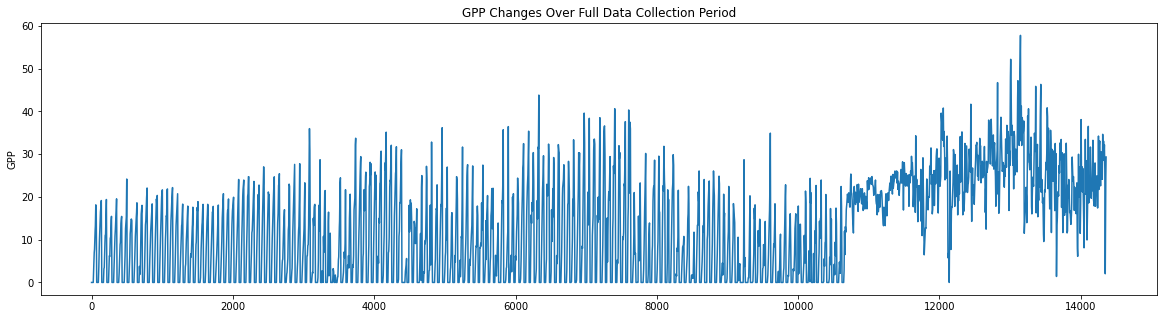

<Figure size 1440x360 with 0 Axes>

In [38]:
import numpy as np
import matplotlib.pyplot as plt

csv_master_path = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset/populatedGPPsMORN.csv"
#csv_master_path = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000/populatedGPPs.csv"
data_info = pd.read_csv(csv_master_path)
GPP_arr = np.asarray(data_info.iloc[:,1])
fig=plt.figure(figsize=(20.0, 5.0))
plt.plot(GPP_arr)
plt.ylabel('GPP')
plt.title("GPP Changes Over Full Data Collection Period")
plt.figure(figsize=(20,5))
os.chdir(r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2")
plt.show()
os.chdir(csvdataLocation)

my_dpi=96

fig.savefig('Morning GPP Changes.png', dpi=my_dpi*5)